In [1]:
import numpy as np
import tqdm
from matplotlib import animation
import time
from gridworld import MarkovGridWorld, OranbeBlue, SarsaGridWorld
import matplotlib.pyplot as plt
from copy import deepcopy

The Hyperparamters

In [2]:
BASE_PARAMETERS ={
    "n_cols": 6,
    "n_rows": 6,
    "walls": [(2, 2), (1, 3), (1, 4), (3, 2)],
    "traps": [(5, 2), (2,4), (1,2), (5,5)],
    "start": (0, 0),
    "goal": (2,3),
    "cost_per_step": 0.05,
    "goal_reward": 3,
    "trap_reward": -1,
    "probality_wrong_step": 0.05
    }

AGENT_PARAMETERS ={
    "epsilon" :0.2,
    "epsilon_anealing_factor" :0.99,
    "max_steps_per_episode"  : 200,
    "gamma" : 0.95
}    

 11%|█▏        | 226/2000 [00:00<00:01, 978.49it/s]


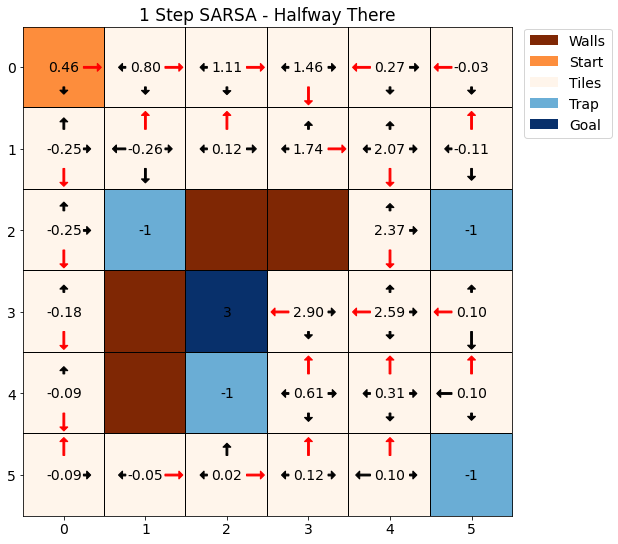

In [3]:
mdp = SarsaGridWorld(BASE_PARAMETERS,
                     alpha = 0.05,
                     n_steps_sarsa = 1,
                     **AGENT_PARAMETERS) 

for i in tqdm.tqdm(range(2000)):

    mdp.step()
    if  mdp.average_return_per_episode() > 0.75:
        
        break

mdp.visualize("1 Step SARSA - Halfway There")
FROZEN_SARSA = deepcopy(mdp)

 21%|██▏       | 1066/5000 [00:00<00:01, 3249.43it/s]


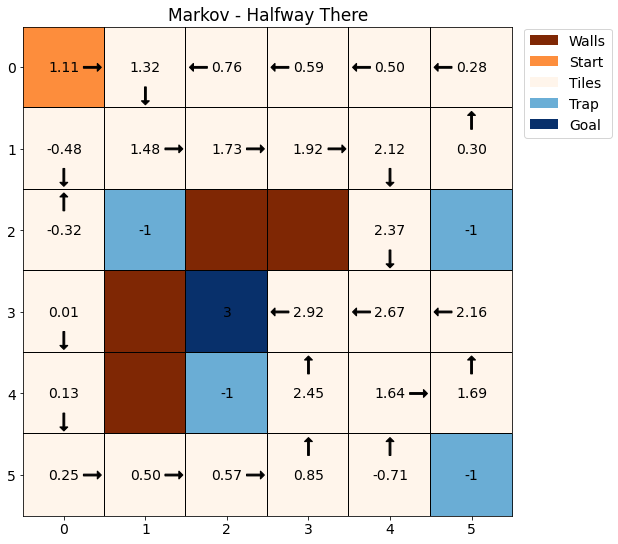

In [17]:
mdp = MarkovGridWorld(BASE_PARAMETERS,
                     **AGENT_PARAMETERS) 


for i in tqdm.tqdm(range(5000)):

    mdp.step()
    if  mdp.average_return_per_episode() > 0.75:
        
        break
        
    

mdp.visualize("Markov - Halfway There")
FROZEN_MARKOV = deepcopy(mdp)

In [18]:
same_epsilon = min(FROZEN_MARKOV.epsilon, FROZEN_SARSA.epsilon)

FROZEN_MARKOV.epsilon = same_epsilon
FROZEN_SARSA.epsilon = same_epsilon

In [19]:
def only_update_start_step_sarsa(mdp, wanted_first_move):
    
    first_move = None
    
    while first_move != wanted_first_move:
        
        episode = mdp.create_episode(mdp.start)
        first_move = episode[1][0]
    

    imediate_rewards, actions_taken, from_states = episode

    history_length = len(imediate_rewards)

    i = 0

    index = i + mdp.n_steps_sarsa

    rewards = imediate_rewards[i: index]
    gammas = mdp.gamma ** np.arange(len(rewards))

    reward = np.dot(rewards, gammas)

    if index < history_length:

        state_action_pair = from_states[index], actions_taken[index]
        q_val = mdp.q_values[state_action_pair]

        reward += (mdp.gamma ** mdp.n_steps_sarsa) * q_val


    cur_sap = from_states[i], actions_taken[i]

    mdp.q_values[cur_sap] += mdp.alpha * \
        (reward - mdp.q_values[cur_sap])

    return mdp.q_values[cur_sap], reward


def update_sarsa_start_N_times(N):
    
    mdp = deepcopy(FROZEN_SARSA)
    
    best_move = mdp.policy[mdp.start]    

    vals = np.array([only_update_start_step_sarsa(mdp, best_move) for _ in range(N)])

    return vals[:,0], vals[:,1]

In [20]:
def only_update_start_step_markov(mpd, wanted_first_move):
    
    first_move = None
    
    while first_move != wanted_first_move:
        
        episode = mdp.create_episode(mdp.start)
        first_move = episode[0][2]

    rewards_after = [x[1] for x in episode[1:]]
    gamma_weigted_return = np.dot(
        rewards_after, mdp.gamma ** np.arange(1, len(episode)))


    # go from back to front
    position, imediate_reward, action, first_visit = episode[0]


    # new state value

    gamma_weigted_return = imediate_reward + mdp.gamma * gamma_weigted_return



    # add to other samples

    mdp.state_values[position] += gamma_weigted_return

    # update gamma sums

    mdp.q_values[(position, action)] += gamma_weigted_return
    
    return mdp.q_values[(position, action)](), gamma_weigted_return

def update_markov_start_N_times(N):
    
    mdp = deepcopy(FROZEN_MARKOV)
    

    best_move = mdp.policy[mdp.start]    
    
    
    vals = np.array([only_update_start_step_markov(mdp, best_move) for _ in range(N)])

    return vals[:,0], vals[:,1]


In [43]:
sarsa_q_vals, sarsa_rewards  = update_sarsa_start_N_times(1000)

markov_q_vals, markov_rewards  = update_markov_start_N_times(1000)

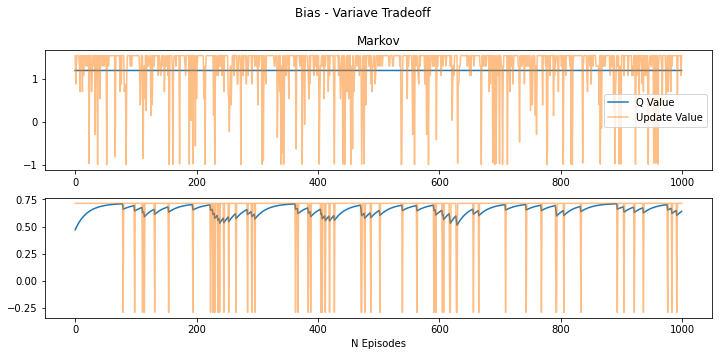

In [45]:
plt.figure(figsize = (10,5))

plt.suptitle("Bias - Variave Tradeoff")

ax1 =plt.subplot(2,1,1)
plt.plot(markov_q_vals, label = "Q Value" )
plt.plot(markov_rewards, label = "Update Value", alpha = 0.5 )
plt.title("Markov")
plt.legend()


ax2 =plt.subplot(2,1,2, sharex = ax1)

plt.plot(sarsa_q_vals, label = "Q Value")
plt.plot(sarsa_rewards, label = "Update Value", alpha = 0.5 )
plt.xlabel("N Episodes")

plt.tight_layout()
plt.savefig("imgs/bias-variance_tradeoff.jpeg")
plt.show()

In [ ]:

plt.figure(figsize = (10,5))

plt.suptitle("Bias - Variave Tradeoff")

ax1 =plt.subplot(2,2,1)
plt.title("Markov")
plt.ylabel("Q(s,a)")

plt.plot(markov_q_vals, )
ax2 =plt.subplot(2,2,3, sharey = ax1)

plt.xlabel("N Episodes")

plt.ylabel("Update Value")


plt.plot(markov_rewards, )

plt.subplot(2,2,4, sharey = ax2)
plt.plot(sarsa_rewards )
plt.xlabel("N Episodes")



ax3 =plt.subplot(2,2,2, sharey = ax1)
plt.plot(sarsa_q_vals)
plt.title("Sarsa")
plt.tight_layout()
plt.savefig("imgs/bias-variance_tradeoff.jpeg")
plt.show()

In [34]:
sarsa_q_vals_stacked  = np.stack([update_sarsa_start_N_times(1000)[0] for i in tqdm.tqdm(range(100))]) 
markov_q_vals_stacked  = np.stack([update_markov_start_N_times(1000)[0] for i in tqdm.tqdm(range(100))]) 

100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


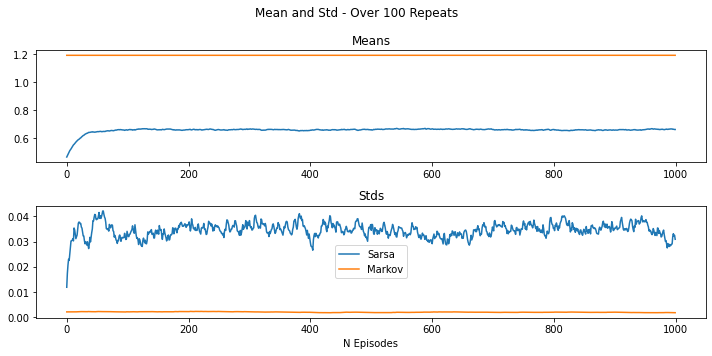

In [41]:
sarsa_mean = sarsa_q_vals_stacked.mean(0)
markov_mean = markov_q_vals_stacked.mean(0)

sarsa_std = sarsa_q_vals_stacked.std(0)
markov_std = markov_q_vals_stacked.std(0)


plt.figure(figsize = (10,5))
plt.subplot(2 ,1 ,1 )
plt.plot(sarsa_mean, label = "Sarsa")
plt.plot(markov_mean, label = "Markov")
plt.title("Means")


plt.subplot(2 ,1 ,2)
plt.plot(sarsa_std, label = "Sarsa")
plt.plot(markov_std, label = "Markov")
plt.title("Stds")
plt.legend()
plt.suptitle("Mean and Std - Over 100 Repeats")
plt.xlabel("N Episodes")
plt.tight_layout()
plt.savefig("imgs/100_repeats.jpeg")
plt.show()